In [3]:
%matplotlib inline

In [1]:
import os
import cv2
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign

# Configuration
IMG_DIR = r"F:\yolov12ckt\dataset\train\images"
LABEL_DIR = r"F:\yolov12ckt\dataset\train\labels"
BATCH_SIZE = 8  # Increased batch size
NUM_EPOCHS = 30
NUM_CLASSES = 22
IMG_SIZE = (640, 640)  # Reduced input size
NUM_WORKERS = 4 if os.name == 'nt' else 8  # Workers for Windows/Linux

# Optimized transforms
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                    std=[0.229, 0.224, 0.225])
])

# Precompute anchor sizes for better RPN performance
anchor_sizes = ((16,), (32,), (64,), (128,), (256,)) 
anchor_generator = AnchorGenerator(
    sizes=anchor_sizes,
    aspect_ratios=((0.5, 1.0, 2.0),) * len(anchor_sizes)
)

# Optimized model backbone
def create_model(num_classes):
    backbone = torchvision.models.mobilenet_v2(pretrained=True).features
    backbone.out_channels = 1280
    
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0'],
        output_size=7,
        sampling_ratio=2
    )
    
    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        min_size=IMG_SIZE[0],
        max_size=IMG_SIZE[1]
    )
    return model

# Optimized Dataset class
class CircuitDataset(Dataset):
    def __init__(self, img_dir, label_dir, transforms=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.images = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        self.cache = {}  # Simple image caching

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]

        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace(".jpg", ".txt"))

        # OpenCV for faster image loading
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w = image.shape[:2]
        
        # Resize with aspect ratio preservation
        scale = min(IMG_SIZE[0]/w, IMG_SIZE[1]/h)
        new_w, new_h = int(w*scale), int(h*scale)
        image = cv2.resize(image, (new_w, new_h))
        
        # Pad to target size
        pad_w = IMG_SIZE[0] - new_w
        pad_h = IMG_SIZE[1] - new_h
        image = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, 
                                 cv2.BORDER_CONSTANT, value=(114,114,114))
        
        # Load and transform labels
        boxes, labels = self.load_labels(label_path, w, h, scale)
        
        # Apply transforms
        if self.transforms:
            image = self.transforms(image)
        else:
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        # Cache the processed item
        self.cache[idx] = (image, {"boxes": boxes, "labels": labels})
        return image, {"boxes": boxes, "labels": labels}

    def load_labels(self, label_path, orig_w, orig_h, scale):
        boxes = []
        labels = []
        try:
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, w, h = map(float, parts[1:5])
                    
                    # Original coordinates
                    x_min = (x_center - w/2) * orig_w
                    y_min = (y_center - h/2) * orig_h
                    x_max = (x_center + w/2) * orig_w
                    y_max = (y_center + h/2) * orig_h
                    
                    # Scaled coordinates
                    x_min *= scale
                    y_min *= scale
                    x_max *= scale
                    y_max *= scale
                    
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(class_id + 1)
        except:
            pass
        
        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        else:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        return boxes, labels

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return images, targets

# Initialize components
dataset = CircuitDataset(IMG_DIR, LABEL_DIR, transform)
data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(NUM_CLASSES).to(device)
scaler = GradScaler()

# Freeze backbone layers
for param in model.backbone.parameters():
    param.requires_grad = False

# Optimized optimizer configuration
optimizer = torch.optim.AdamW([
    {'params': model.rpn.parameters(), 'lr': 1e-4},
    {'params': model.roi_heads.parameters(), 'lr': 1e-4}
])

# Training loop with mixed precision
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    
    for images, targets in data_loader:
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
        
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += losses.item()
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] Loss: {total_loss/len(data_loader):.4f}")

torch.save(model.state_dict(), "optimized_faster_rcnn.pth")

c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\harsh/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [05:29<00:00, 43.1kB/s]
C:\Users\harsh\AppData\Local\Temp\ipykernel_10884\2223297753.py:157: FutureWarning: `torch.cuda.amp.

RuntimeError: DataLoader worker (pid(s) 9904, 18240, 5464, 14764) exited unexpectedly

In [5]:
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models, regularizers
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image

c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import torch

# Load the PyTorch model
model_path = r'F:\yolov12ckt\runs\detect\train29\weights\best.pt'  # Ensure the path is correct
loaded_model = torch.load(model_path, map_location=torch.device('cpu'))  # Load to CPU for compatibility

loaded_model

C:\Users\harsh\AppData\Local\Temp\ipykernel_17548\3077569394.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(model_path, map_location=torch.dev

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


{'date': '2025-03-06T10:19:02.037408',
 'version': '8.3.63',
 'license': 'AGPL-3.0 (https://ultralytics.com/license)',
 'docs': 'https://docs.ultralytics.com',
 'epoch': -1,
 'best_fitness': None,
 'model': DetectionModel(
   (model): Sequential(
     (0): Conv(
       (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (1): Conv(
       (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
       (act): SiLU(inplace=True)
     )
     (2): C3k2(
       (cv1): Conv(
         (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
         (act): SiLU(inplace=True)
       )
       (

In [13]:
import os
import pandas as pd

# Dataset directories
train_dir = r'F:\yolov12ckt\dataset\train'
validation_dir = r'F:\yolov12ckt\dataset\valid'
test_dir = r'F:\yolov12ckt\dataset\test'

def get_paths(directory):
    """
    Recursively get all image file paths from the dataset directory.
    This will find images even if they are inside subdirectories.
    """
    if not os.path.exists(directory):
        print(f"Warning: Directory '{directory}' is missing!")
        return [], pd.DataFrame()

    # Collect all image paths (including subdirectories)
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tiff')):  # Add more formats if needed
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        print(f"Warning: No images found in {directory}!")

    # Create DataFrame for easier handling
    directory_df = pd.DataFrame({"image_path": image_paths})

    return image_paths, directory_df

# Get dataset paths
train_path_list, train_df = get_paths(train_dir)
valid_path_list, valid_df = get_paths(validation_dir)
test_path_list, test_df = get_paths(test_dir)

# Print dataset summary
print(f"Training set: {len(train_path_list)} images")
print(f"Validation set: {len(valid_path_list)} images")
print(f"Test set: {len(test_path_list)} images")


Training set: 717 images
Validation set: 205 images
Test set: 103 images


In [14]:
def preprocess_image(path_list):
    output = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = np.divide(x, 255.0) # rescale should match what was used for model training
        output.append(x)
    return np.vstack(output)
images = preprocess_image(train_path_list)
images[0].shape

(299, 299, 3)

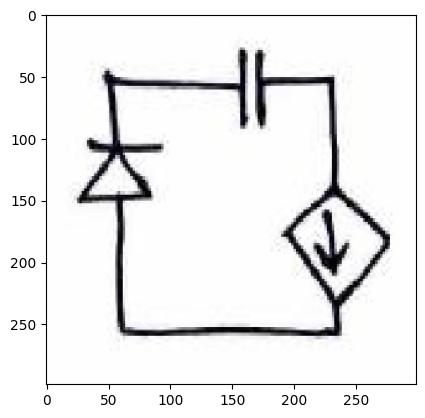

In [15]:
# Choose an image for explanation
xray = images[0]
plt.imshow(xray);

In [44]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=23)
model.load_state_dict(torch.load(r"F:\yolov12ckt\faster_rcnn_cnn_model.pt"))
model.eval()  # Set to evaluation mode


c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\harsh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\harsh/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [01:12<00:00, 1.42MB/s]


RuntimeError: Error(s) in loading state_dict for FasterRCNN:
	Missing key(s) in state_dict: "backbone.body.conv1.weight", "backbone.body.bn1.weight", "backbone.body.bn1.bias", "backbone.body.bn1.running_mean", "backbone.body.bn1.running_var", "backbone.body.layer1.0.conv1.weight", "backbone.body.layer1.0.bn1.weight", "backbone.body.layer1.0.bn1.bias", "backbone.body.layer1.0.bn1.running_mean", "backbone.body.layer1.0.bn1.running_var", "backbone.body.layer1.0.conv2.weight", "backbone.body.layer1.0.bn2.weight", "backbone.body.layer1.0.bn2.bias", "backbone.body.layer1.0.bn2.running_mean", "backbone.body.layer1.0.bn2.running_var", "backbone.body.layer1.0.conv3.weight", "backbone.body.layer1.0.bn3.weight", "backbone.body.layer1.0.bn3.bias", "backbone.body.layer1.0.bn3.running_mean", "backbone.body.layer1.0.bn3.running_var", "backbone.body.layer1.0.downsample.0.weight", "backbone.body.layer1.0.downsample.1.weight", "backbone.body.layer1.0.downsample.1.bias", "backbone.body.layer1.0.downsample.1.running_mean", "backbone.body.layer1.0.downsample.1.running_var", "backbone.body.layer1.1.conv1.weight", "backbone.body.layer1.1.bn1.weight", "backbone.body.layer1.1.bn1.bias", "backbone.body.layer1.1.bn1.running_mean", "backbone.body.layer1.1.bn1.running_var", "backbone.body.layer1.1.conv2.weight", "backbone.body.layer1.1.bn2.weight", "backbone.body.layer1.1.bn2.bias", "backbone.body.layer1.1.bn2.running_mean", "backbone.body.layer1.1.bn2.running_var", "backbone.body.layer1.1.conv3.weight", "backbone.body.layer1.1.bn3.weight", "backbone.body.layer1.1.bn3.bias", "backbone.body.layer1.1.bn3.running_mean", "backbone.body.layer1.1.bn3.running_var", "backbone.body.layer1.2.conv1.weight", "backbone.body.layer1.2.bn1.weight", "backbone.body.layer1.2.bn1.bias", "backbone.body.layer1.2.bn1.running_mean", "backbone.body.layer1.2.bn1.running_var", "backbone.body.layer1.2.conv2.weight", "backbone.body.layer1.2.bn2.weight", "backbone.body.layer1.2.bn2.bias", "backbone.body.layer1.2.bn2.running_mean", "backbone.body.layer1.2.bn2.running_var", "backbone.body.layer1.2.conv3.weight", "backbone.body.layer1.2.bn3.weight", "backbone.body.layer1.2.bn3.bias", "backbone.body.layer1.2.bn3.running_mean", "backbone.body.layer1.2.bn3.running_var", "backbone.body.layer2.0.conv1.weight", "backbone.body.layer2.0.bn1.weight", "backbone.body.layer2.0.bn1.bias", "backbone.body.layer2.0.bn1.running_mean", "backbone.body.layer2.0.bn1.running_var", "backbone.body.layer2.0.conv2.weight", "backbone.body.layer2.0.bn2.weight", "backbone.body.layer2.0.bn2.bias", "backbone.body.layer2.0.bn2.running_mean", "backbone.body.layer2.0.bn2.running_var", "backbone.body.layer2.0.conv3.weight", "backbone.body.layer2.0.bn3.weight", "backbone.body.layer2.0.bn3.bias", "backbone.body.layer2.0.bn3.running_mean", "backbone.body.layer2.0.bn3.running_var", "backbone.body.layer2.0.downsample.0.weight", "backbone.body.layer2.0.downsample.1.weight", "backbone.body.layer2.0.downsample.1.bias", "backbone.body.layer2.0.downsample.1.running_mean", "backbone.body.layer2.0.downsample.1.running_var", "backbone.body.layer2.1.conv1.weight", "backbone.body.layer2.1.bn1.weight", "backbone.body.layer2.1.bn1.bias", "backbone.body.layer2.1.bn1.running_mean", "backbone.body.layer2.1.bn1.running_var", "backbone.body.layer2.1.conv2.weight", "backbone.body.layer2.1.bn2.weight", "backbone.body.layer2.1.bn2.bias", "backbone.body.layer2.1.bn2.running_mean", "backbone.body.layer2.1.bn2.running_var", "backbone.body.layer2.1.conv3.weight", "backbone.body.layer2.1.bn3.weight", "backbone.body.layer2.1.bn3.bias", "backbone.body.layer2.1.bn3.running_mean", "backbone.body.layer2.1.bn3.running_var", "backbone.body.layer2.2.conv1.weight", "backbone.body.layer2.2.bn1.weight", "backbone.body.layer2.2.bn1.bias", "backbone.body.layer2.2.bn1.running_mean", "backbone.body.layer2.2.bn1.running_var", "backbone.body.layer2.2.conv2.weight", "backbone.body.layer2.2.bn2.weight", "backbone.body.layer2.2.bn2.bias", "backbone.body.layer2.2.bn2.running_mean", "backbone.body.layer2.2.bn2.running_var", "backbone.body.layer2.2.conv3.weight", "backbone.body.layer2.2.bn3.weight", "backbone.body.layer2.2.bn3.bias", "backbone.body.layer2.2.bn3.running_mean", "backbone.body.layer2.2.bn3.running_var", "backbone.body.layer2.3.conv1.weight", "backbone.body.layer2.3.bn1.weight", "backbone.body.layer2.3.bn1.bias", "backbone.body.layer2.3.bn1.running_mean", "backbone.body.layer2.3.bn1.running_var", "backbone.body.layer2.3.conv2.weight", "backbone.body.layer2.3.bn2.weight", "backbone.body.layer2.3.bn2.bias", "backbone.body.layer2.3.bn2.running_mean", "backbone.body.layer2.3.bn2.running_var", "backbone.body.layer2.3.conv3.weight", "backbone.body.layer2.3.bn3.weight", "backbone.body.layer2.3.bn3.bias", "backbone.body.layer2.3.bn3.running_mean", "backbone.body.layer2.3.bn3.running_var", "backbone.body.layer3.0.conv1.weight", "backbone.body.layer3.0.bn1.weight", "backbone.body.layer3.0.bn1.bias", "backbone.body.layer3.0.bn1.running_mean", "backbone.body.layer3.0.bn1.running_var", "backbone.body.layer3.0.conv2.weight", "backbone.body.layer3.0.bn2.weight", "backbone.body.layer3.0.bn2.bias", "backbone.body.layer3.0.bn2.running_mean", "backbone.body.layer3.0.bn2.running_var", "backbone.body.layer3.0.conv3.weight", "backbone.body.layer3.0.bn3.weight", "backbone.body.layer3.0.bn3.bias", "backbone.body.layer3.0.bn3.running_mean", "backbone.body.layer3.0.bn3.running_var", "backbone.body.layer3.0.downsample.0.weight", "backbone.body.layer3.0.downsample.1.weight", "backbone.body.layer3.0.downsample.1.bias", "backbone.body.layer3.0.downsample.1.running_mean", "backbone.body.layer3.0.downsample.1.running_var", "backbone.body.layer3.1.conv1.weight", "backbone.body.layer3.1.bn1.weight", "backbone.body.layer3.1.bn1.bias", "backbone.body.layer3.1.bn1.running_mean", "backbone.body.layer3.1.bn1.running_var", "backbone.body.layer3.1.conv2.weight", "backbone.body.layer3.1.bn2.weight", "backbone.body.layer3.1.bn2.bias", "backbone.body.layer3.1.bn2.running_mean", "backbone.body.layer3.1.bn2.running_var", "backbone.body.layer3.1.conv3.weight", "backbone.body.layer3.1.bn3.weight", "backbone.body.layer3.1.bn3.bias", "backbone.body.layer3.1.bn3.running_mean", "backbone.body.layer3.1.bn3.running_var", "backbone.body.layer3.2.conv1.weight", "backbone.body.layer3.2.bn1.weight", "backbone.body.layer3.2.bn1.bias", "backbone.body.layer3.2.bn1.running_mean", "backbone.body.layer3.2.bn1.running_var", "backbone.body.layer3.2.conv2.weight", "backbone.body.layer3.2.bn2.weight", "backbone.body.layer3.2.bn2.bias", "backbone.body.layer3.2.bn2.running_mean", "backbone.body.layer3.2.bn2.running_var", "backbone.body.layer3.2.conv3.weight", "backbone.body.layer3.2.bn3.weight", "backbone.body.layer3.2.bn3.bias", "backbone.body.layer3.2.bn3.running_mean", "backbone.body.layer3.2.bn3.running_var", "backbone.body.layer3.3.conv1.weight", "backbone.body.layer3.3.bn1.weight", "backbone.body.layer3.3.bn1.bias", "backbone.body.layer3.3.bn1.running_mean", "backbone.body.layer3.3.bn1.running_var", "backbone.body.layer3.3.conv2.weight", "backbone.body.layer3.3.bn2.weight", "backbone.body.layer3.3.bn2.bias", "backbone.body.layer3.3.bn2.running_mean", "backbone.body.layer3.3.bn2.running_var", "backbone.body.layer3.3.conv3.weight", "backbone.body.layer3.3.bn3.weight", "backbone.body.layer3.3.bn3.bias", "backbone.body.layer3.3.bn3.running_mean", "backbone.body.layer3.3.bn3.running_var", "backbone.body.layer3.4.conv1.weight", "backbone.body.layer3.4.bn1.weight", "backbone.body.layer3.4.bn1.bias", "backbone.body.layer3.4.bn1.running_mean", "backbone.body.layer3.4.bn1.running_var", "backbone.body.layer3.4.conv2.weight", "backbone.body.layer3.4.bn2.weight", "backbone.body.layer3.4.bn2.bias", "backbone.body.layer3.4.bn2.running_mean", "backbone.body.layer3.4.bn2.running_var", "backbone.body.layer3.4.conv3.weight", "backbone.body.layer3.4.bn3.weight", "backbone.body.layer3.4.bn3.bias", "backbone.body.layer3.4.bn3.running_mean", "backbone.body.layer3.4.bn3.running_var", "backbone.body.layer3.5.conv1.weight", "backbone.body.layer3.5.bn1.weight", "backbone.body.layer3.5.bn1.bias", "backbone.body.layer3.5.bn1.running_mean", "backbone.body.layer3.5.bn1.running_var", "backbone.body.layer3.5.conv2.weight", "backbone.body.layer3.5.bn2.weight", "backbone.body.layer3.5.bn2.bias", "backbone.body.layer3.5.bn2.running_mean", "backbone.body.layer3.5.bn2.running_var", "backbone.body.layer3.5.conv3.weight", "backbone.body.layer3.5.bn3.weight", "backbone.body.layer3.5.bn3.bias", "backbone.body.layer3.5.bn3.running_mean", "backbone.body.layer3.5.bn3.running_var", "backbone.body.layer4.0.conv1.weight", "backbone.body.layer4.0.bn1.weight", "backbone.body.layer4.0.bn1.bias", "backbone.body.layer4.0.bn1.running_mean", "backbone.body.layer4.0.bn1.running_var", "backbone.body.layer4.0.conv2.weight", "backbone.body.layer4.0.bn2.weight", "backbone.body.layer4.0.bn2.bias", "backbone.body.layer4.0.bn2.running_mean", "backbone.body.layer4.0.bn2.running_var", "backbone.body.layer4.0.conv3.weight", "backbone.body.layer4.0.bn3.weight", "backbone.body.layer4.0.bn3.bias", "backbone.body.layer4.0.bn3.running_mean", "backbone.body.layer4.0.bn3.running_var", "backbone.body.layer4.0.downsample.0.weight", "backbone.body.layer4.0.downsample.1.weight", "backbone.body.layer4.0.downsample.1.bias", "backbone.body.layer4.0.downsample.1.running_mean", "backbone.body.layer4.0.downsample.1.running_var", "backbone.body.layer4.1.conv1.weight", "backbone.body.layer4.1.bn1.weight", "backbone.body.layer4.1.bn1.bias", "backbone.body.layer4.1.bn1.running_mean", "backbone.body.layer4.1.bn1.running_var", "backbone.body.layer4.1.conv2.weight", "backbone.body.layer4.1.bn2.weight", "backbone.body.layer4.1.bn2.bias", "backbone.body.layer4.1.bn2.running_mean", "backbone.body.layer4.1.bn2.running_var", "backbone.body.layer4.1.conv3.weight", "backbone.body.layer4.1.bn3.weight", "backbone.body.layer4.1.bn3.bias", "backbone.body.layer4.1.bn3.running_mean", "backbone.body.layer4.1.bn3.running_var", "backbone.body.layer4.2.conv1.weight", "backbone.body.layer4.2.bn1.weight", "backbone.body.layer4.2.bn1.bias", "backbone.body.layer4.2.bn1.running_mean", "backbone.body.layer4.2.bn1.running_var", "backbone.body.layer4.2.conv2.weight", "backbone.body.layer4.2.bn2.weight", "backbone.body.layer4.2.bn2.bias", "backbone.body.layer4.2.bn2.running_mean", "backbone.body.layer4.2.bn2.running_var", "backbone.body.layer4.2.conv3.weight", "backbone.body.layer4.2.bn3.weight", "backbone.body.layer4.2.bn3.bias", "backbone.body.layer4.2.bn3.running_mean", "backbone.body.layer4.2.bn3.running_var", "backbone.fpn.inner_blocks.0.0.weight", "backbone.fpn.inner_blocks.0.0.bias", "backbone.fpn.inner_blocks.1.0.weight", "backbone.fpn.inner_blocks.1.0.bias", "backbone.fpn.inner_blocks.2.0.weight", "backbone.fpn.inner_blocks.2.0.bias", "backbone.fpn.inner_blocks.3.0.weight", "backbone.fpn.inner_blocks.3.0.bias", "backbone.fpn.layer_blocks.0.0.weight", "backbone.fpn.layer_blocks.0.0.bias", "backbone.fpn.layer_blocks.1.0.weight", "backbone.fpn.layer_blocks.1.0.bias", "backbone.fpn.layer_blocks.2.0.weight", "backbone.fpn.layer_blocks.2.0.bias", "backbone.fpn.layer_blocks.3.0.weight", "backbone.fpn.layer_blocks.3.0.bias", "rpn.head.conv.0.0.weight", "rpn.head.conv.0.0.bias", "rpn.head.cls_logits.weight", "rpn.head.cls_logits.bias", "rpn.head.bbox_pred.weight", "rpn.head.bbox_pred.bias", "roi_heads.box_head.fc6.weight", "roi_heads.box_head.fc6.bias", "roi_heads.box_head.fc7.weight", "roi_heads.box_head.fc7.bias", "roi_heads.box_predictor.cls_score.weight", "roi_heads.box_predictor.cls_score.bias", "roi_heads.box_predictor.bbox_pred.weight", "roi_heads.box_predictor.bbox_pred.bias". 
	Unexpected key(s) in state_dict: "fc.0.weight", "fc.0.bias". 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

# Select an image from the dataset
xray = images[0]  # Choose an image
plt.imshow(xray)  # Display the image
plt.title("Selected Circuit Image")
plt.axis("off")
plt.show()

# Convert to PIL Image if it's a NumPy array
if isinstance(xray, np.ndarray):
    xray = Image.fromarray(xray)

# Apply transformations for Faster R-CNN (PyTorch version)
transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor()
])
input_image = transform(xray).unsqueeze(0)  # Add batch dimension


In [ ]:
import numpy as np

def predict_fn(images):
    model.eval()
    images = [transform(Image.fromarray(img)) for img in images]  # Convert back to tensor
    outputs = model(images)  # Get predictions

    # Convert bounding box detections into a format LIME can use
    scores = [output["scores"].detach().numpy() for output in outputs]
    labels = [output["labels"].detach().numpy() for output in outputs]

    # Create a probability matrix (num_samples, num_classes)
    prob_matrix = np.zeros((len(images), YOUR_NUM_CLASSES))
    for i, (score, label) in enumerate(zip(scores, labels)):
        prob_matrix[i, label] = score  # Assign scores to respective classes
    
    return prob_matrix


100%|██████████| 1000/1000 [01:22<00:00, 12.07it/s]


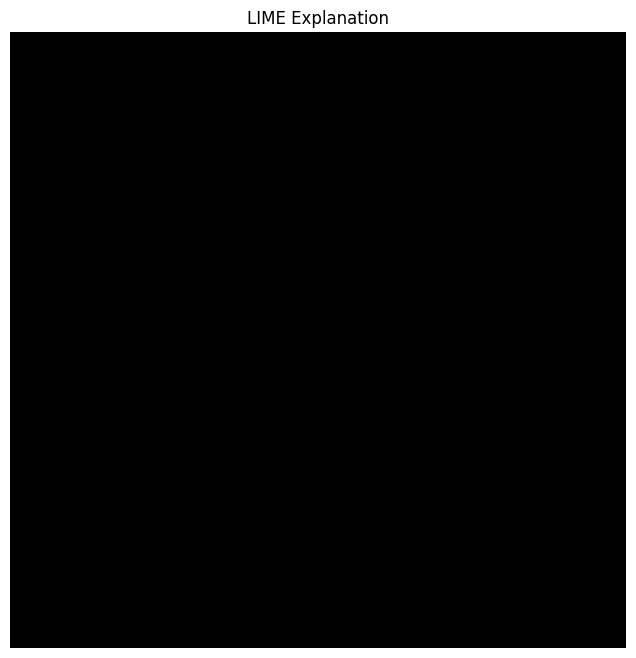

In [43]:
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from lime import lime_image

# Convert grayscale image to RGB if necessary
if len(xray.shape) == 2:  # If grayscale
    xray = np.stack([xray] * 3, axis=-1)  # Convert to RGB

# Convert NumPy array to PIL Image
xray_pil = Image.fromarray(xray.astype(np.uint8))

# Define the prediction function for LIME
def predict_fn(images):
    transform = transforms.Compose([
        transforms.Resize((640, 640)),  # Resize for YOLO
        transforms.ToTensor(),  # Convert to tensor (C, H, W)
    ])
    
    # Convert each image to tensor
    images_tensors = torch.stack([transform(Image.fromarray(img)) for img in images])  # (B, C, H, W)
    
    # Normalize images
    images_tensors = images_tensors.float() / 255.0  # Normalize
    
    # Pass through YOLO model
    results = loaded_model(images_tensors)  # YOLO inference
    preds = results[0].probs.data.numpy() if results[0].probs is not None else np.zeros((len(images), 5))
    
    return preds

# Instantiate LIME Explainer
explainer = lime_image.LimeImageExplainer()

# Explain instance
explanation = explainer.explain_instance(
    np.array(xray_pil),  # Convert back to NumPy for LIME
    predict_fn, 
    top_labels=5, 
    hide_color=None, 
    num_samples=1000
)

# Get LIME mask
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)

# Display explanation
plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis("off")
plt.show()



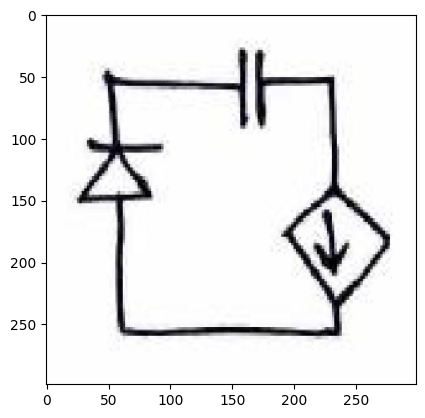

In [37]:
# Include the rest of the image
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

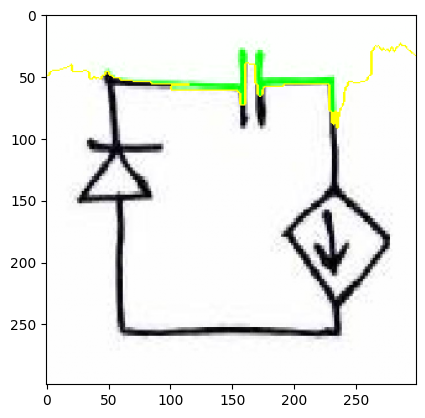

In [38]:
# View the pros and cons
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask));

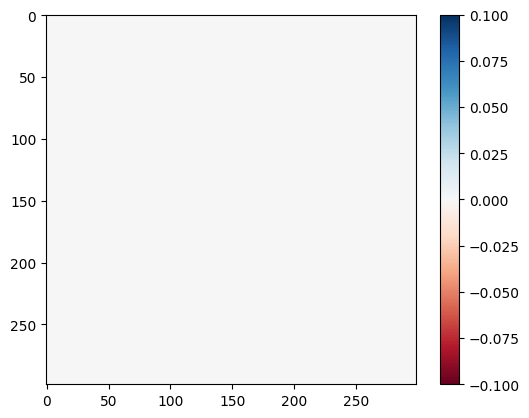

In [39]:
ind =  explanation.top_labels[0]
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar();